# Векторный поиск в задаче матчинга

**Задача:** реализовать усеченную задачу матчинга - определить, являются ли два или более предмета эквивалентными или одним и тем же объектом.

**Описание:** в базе данных (base) хранится информация о продуктах, которые могут быть предложены для покупки. Запрос (query) представляет из себя набор конкретных продуктов, для которых необходимо найти соответствие в базе данных. Задача состоит в том, чтобы автоматически сопоставить запрос с подходящим элементом из базы данных и предоставить пользователю наиболее релевантный результат. Это позволяет снизить дублирование товаров и упростить процесс управления продуктами, что способствует увеличению эффективности и экономии времени.

**Метрика:** Метрикой в данной задаче является Recall@10. Для каждого товара находим 10 наиболее близких кандидатов. Тогда:

**Recall@10 = (общая сумма найденных в топ10 матчей) / (общая сумма матчей)**

В базе данных почти 3 миллиона строк и полезно использовать зарекомендовавшие себя реализации векторного поиска. Одной из таких реализаций является FAISS:

https://github.com/facebookresearch/faiss/wiki

https://habr.com/ru/companies/okkamgroup/articles/509204/

https://habr.com/ru/companies/ozontech/articles/648231/

https://www.youtube.com/watch?v=F7RG-M2PCKo&ab_channel=AliTech

Логичным продолжением и совершенствованием результатов FAISS будет реранкинг с помощью ML, например CatBoost:

https://github.com/catboost/catboost/blob/master/catboost/tutorials/ranking/ranking_tutorial.ipynb

# Импорт библиотек

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import joblib
from IPython.display import IFrame, Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import normalize
from sklearn.linear_model import SGDClassifier

try:
    import faiss
except ModuleNotFoundError:
    !pip install faiss-cpu --quiet
    import faiss

try:
    import phik
except ModuleNotFoundError:
    !pip install phik --quiet
    import phik

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/samokattechworkshop/base.csv
/kaggle/input/samokattechworkshop/train.csv
/kaggle/input/samokattechworkshop/test.csv
/kaggle/input/samokattechworkshop/baseline.ipynb
/kaggle/input/samokattechworkshop/answer_sample.csv


In [2]:
RECOUNT_NOTEBOOK = False
RANDOM_SEED = 12345
np.random.seed(RANDOM_SEED)
pd.set_option('display.max_rows', 100)

In [3]:
def compare_scaler(df:pd.DataFrame):
    left_border = df.min()
    right_border = df.max()
    center = (right_border + left_border) / 2
    mean = df.mean()
    std = df.std()
    
    left_border = f"{left_border.mean():.2f} ± {left_border.std():.2f}"
    right_border = f"{right_border.mean():.2f} ± {right_border.std():.2f}"
    center = f"{center.mean():.2f} ± {center.std():.2f}"
    mean = f"{mean.mean():.2f} ± {mean.std():.2f}"
    std = f"{std.mean():.2f} ± {std.std():.2f}"
    
    return (left_border, center, right_border, mean, std)

In [4]:
def L2_dist(X_train:np.array, y_train:np.array, marks:np.array)->np.array:
    #marks - совпал или нет объект
    assert X_train.shape == y_train.shape
    dist = np.zeros((X_train.shape[0], X_train.shape[1] + 2))
    cond = np.full(X_train.shape[1], True)

    for obj in range(X_train.shape[0]):
        dist[obj, -2] = distance.euclidean(X_train[obj], y_train[obj])
        dist[obj, -1] = marks[obj].astype('int')
        if dist[obj, -2] != 0:
            for col in range(X_train.shape[1]):        
                cond[col] = False
                dist[obj, col] = (dist[obj, -2] - distance.euclidean(X_train[obj, cond], y_train[obj, cond])) / dist[obj, -2]
                cond[col] = True
    return dist

# Загрузка и обзор данных

In [5]:
base = pd.read_csv('/kaggle/input/samokattechworkshop/base.csv')
base.shape

(2918139, 73)

In [6]:
display(base.head(3))

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.93361,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.93793,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.07349,116.594154,-1074.464888,-32.527206


In [7]:
train = pd.read_csv('/kaggle/input/samokattechworkshop/train.csv')
train.shape

(100000, 74)

In [8]:
display(train.head(3))

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.12843,-50.83762,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.93147,-1074.464888,-22.547178,1447819-base


In [9]:
test = pd.read_csv('/kaggle/input/samokattechworkshop/test.csv')
test.shape

(100000, 73)

In [10]:
display(test.head(3))

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604


**Выводы**

* данные для работы модели представлены в трех таблицах в векторном виде;
* таблицы довольно большие: 72 признака и почти 3млн строк в base, для быстрого поиска ближайших соседей и кластеризации в векторном пространстве будем использоват библиотеку FAISS (Facebook AI Research Similarity Search);
* данные в разном масштабе, поэтому перед подачей в модели будет необходимо их обработать.

# Исследовательский анализ данных

In [11]:
base.set_index('Id', inplace = True)

## Анализ распределения признаков

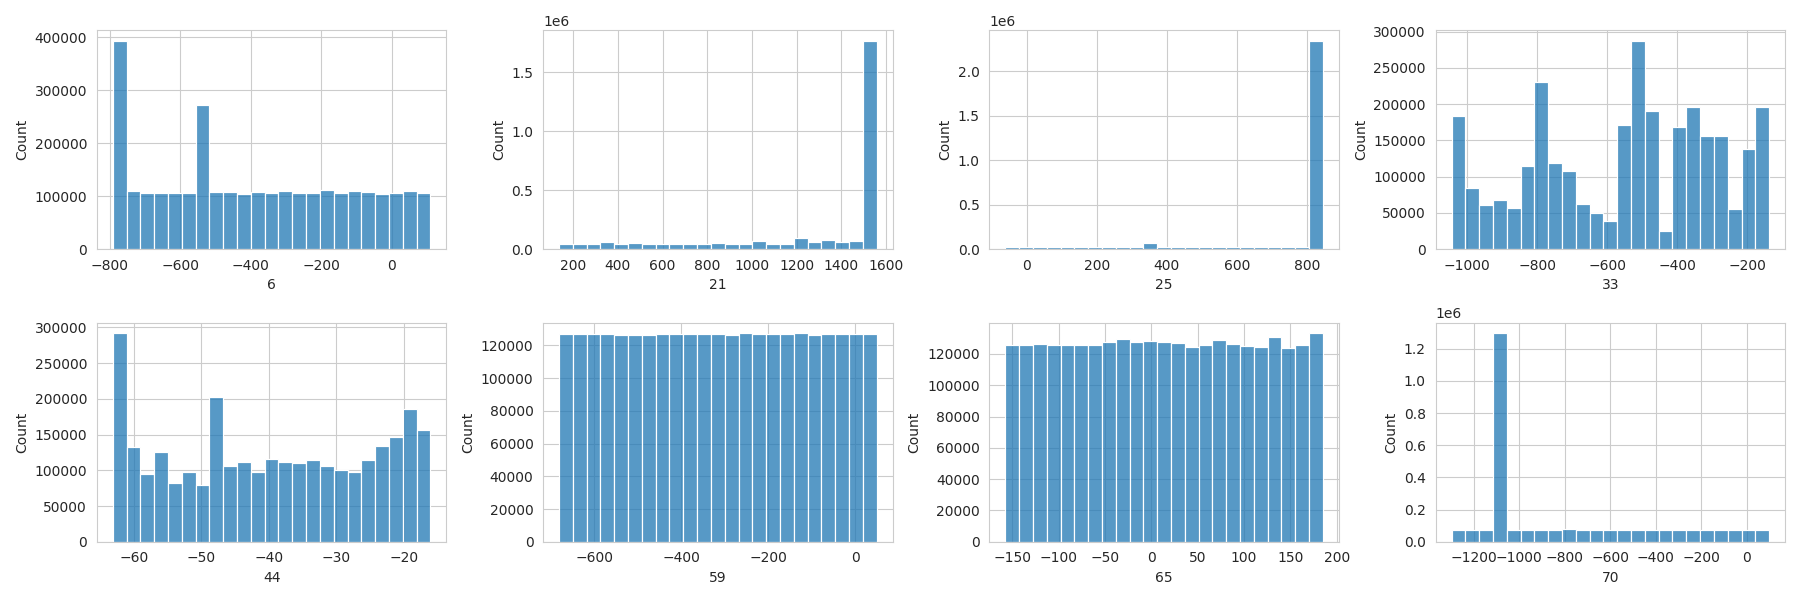

CPU times: user 4.4 ms, sys: 0 ns, total: 4.4 ms
Wall time: 4.19 ms


In [12]:
%%time
file_name = 'hist_features.png'
if not os.path.isfile(file_name) or RECOUNT_NOTEBOOK:
    subset_cols = ['6', '21', '25', '33', '44', '59', '65', '70']
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(ncols=4, nrows = 2, figsize=(18, 6))
    cols_cnt, cols_len = 0, len(subset_cols)
    subset_cols = iter(subset_cols)
    for row in range(len(ax)):
        for plot in ax[row]:
            col = next(subset_cols)
            sns.histplot(ax = plot, x = base[col], bins = 'sturges')
            cols_cnt += 1
            print(f"\r{cols_cnt}/{cols_len} done!", end = '')
    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()
else:
    display(Image(file_name))

В процессе первичного визуального анализа распределения признаков установлено:
* всего в наборе base 72 поля с численными признаками и 1 поле `Id` с категориальными данными;
* 64 признака имеют распределение близкое к нормальному, 8 признаков имеют другие виды распределений.

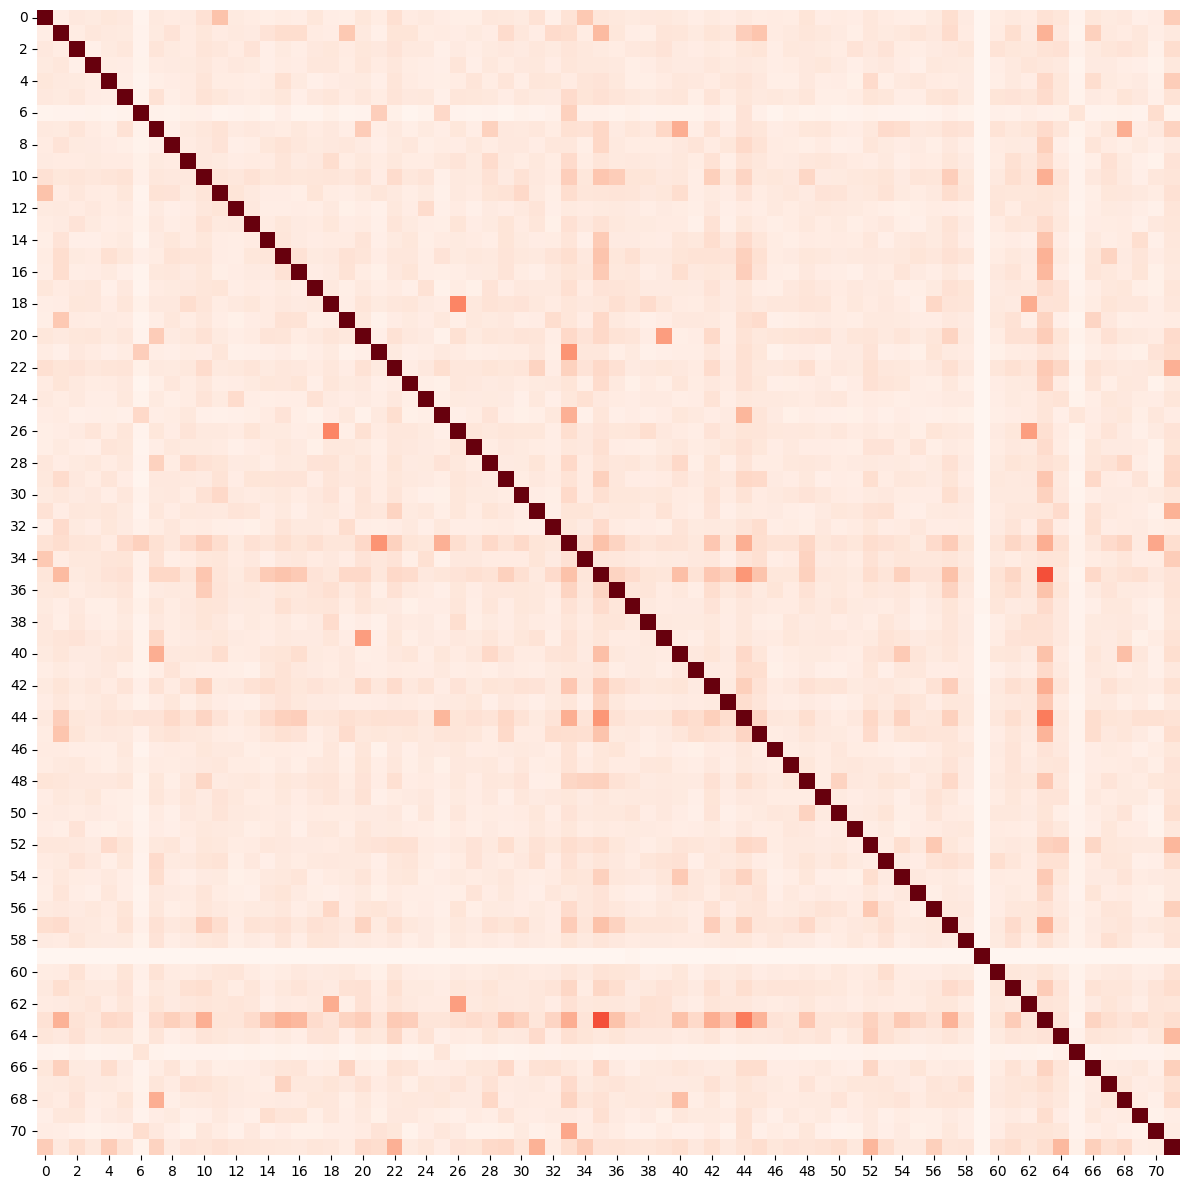

CPU times: user 894 ms, sys: 312 ms, total: 1.21 s
Wall time: 723 ms


In [13]:
%%time
matrix_name = 'phik_full_matrix.csv'
if not os.path.isfile(matrix_name) or RECOUNT_NOTEBOOK:
    corr_matrix = base.phik_matrix(interval_cols = base.columns, drop_underflow = False)
    corr_matrix.to_csv(matrix_name, index=False)
else:
    corr_matrix = pd.read_csv(matrix_name)
plt.figure(figsize = (12, 12))
sns.heatmap(corr_matrix, cmap = 'Reds', cbar = False)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод**

Некоторые из ранее обнаруженных признаков форма распределения которых не похожа на нормальную, показывают практически нулевую корреляцию с другими признаками. Можно сделать предварительный вывод, что это некачественные признаки, от которых лучше избавиться.

# Подготовка данных

Рассмотрим несколько способов предобработки численных данных:
* StandardScaler - эффективное средство, центрирует данные по мат. ожиданию (мат. ожидание становится равным нулю) и скалирует по среднеквадратичному отклонению. Из-за деления на std диапазон выходных данных может различаться для разных признаков, плюс данный скалер никак не работает с формой распределения - она остается той же;
* PowerTransformer - под капотом тот же StandardScaler + нелинейное преобразование Йео-Джонсона и блягодаря ему PowerTransformer как раз может исправлять скошенные и равномерные распределения - посмотрим на него в надежде, что он исправит отмеченные выше признаки с не нормальным распределением;
* QuantileTransformer с двумя типами выходных распределений - также относится к трансформерам с нелинейным преобразованием входных данных, который (в теории) также может исправить признаки.

Для демонстрации работы трансформеров рассмотрим те самые "плохие" признаки:

## Центрирование и масштабирование данных

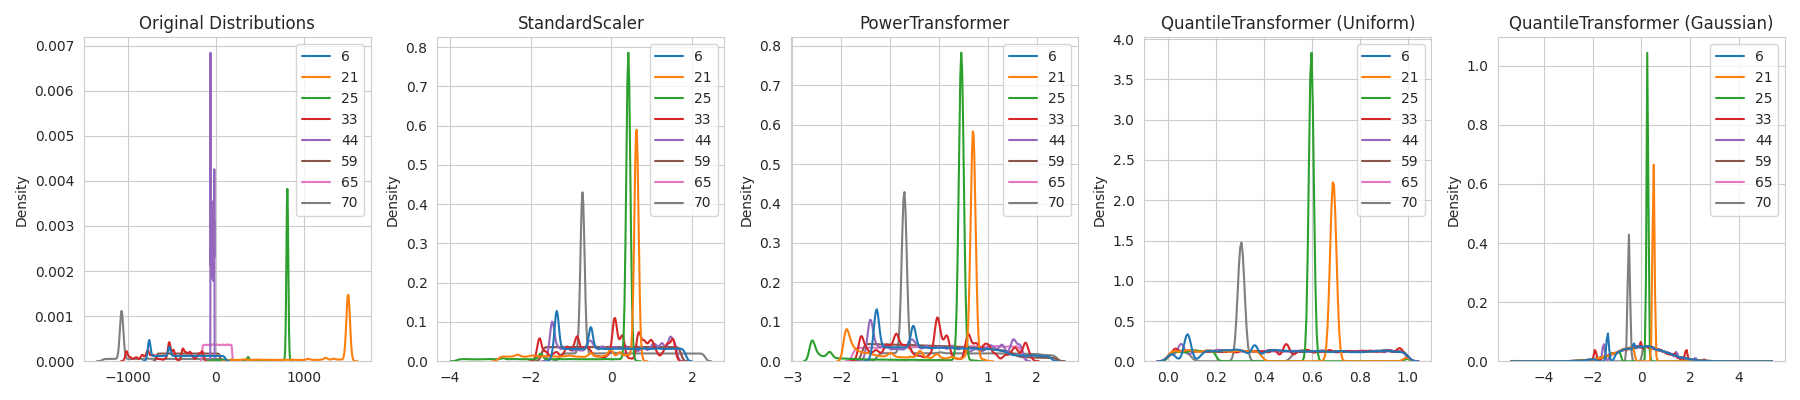

CPU times: user 11.7 ms, sys: 2.03 ms, total: 13.7 ms
Wall time: 12.3 ms


In [14]:
%%time
file_name = 'kde_scalers.png'
dataframe_name = 'scalers_compare.csv'
if not os.path.isfile(file_name) or RECOUNT_NOTEBOOK:
    subset_cols = ['6', '21', '25', '33', '44', '59', '65', '70']
    scale_algorithms = iter([
        ('Original Distributions', None),
        ('StandardScaler', StandardScaler()),
        ('PowerTransformer', PowerTransformer()),
        ('QuantileTransformer (Uniform)', QuantileTransformer(n_quantiles = 1000)),
        ('QuantileTransformer (Gaussian)', QuantileTransformer(output_distribution='normal', n_quantiles = 1000))
    ])
    compare_df = pd.DataFrame(columns = ['Left border', 'Center', 'Right border', 'Mean', 'Std'])
    fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize=(18, 4))
    cols_cnt, cols_len = 0, len(ax)
    for plot in ax:
        scaler = next(scale_algorithms)
        plot.set_title(scaler[0])
        if scaler[1] is not None:
            scale_data = pd.DataFrame(data = scaler[1].fit_transform(base[subset_cols]), index = base.index, 
                                      columns = subset_cols)        
            sns.kdeplot(ax = plot, data = scale_data)
            compare_df.loc[scaler[0]] = compare_scaler(scale_data)
        else:
            sns.kdeplot(ax = plot, data = base[subset_cols])
            compare_df.loc[scaler[0]] = compare_scaler(base[subset_cols])
        cols_cnt += 1
        print(f"\r{cols_cnt}/{cols_len} done!", end = '')
    compare_df.to_csv(dataframe_name)
    plt.tight_layout()    
    plt.savefig(file_name)
    plt.show()
else:
    compare_df = pd.read_csv(dataframe_name)
    display(Image(file_name))    

Визуально кажется, что бóльшего успеха в деле нормализации признаков добился квантильный трансформер. Однако для дальнейшей работы я выберу PowerTransformer, т.к. из прошлого опыта я сделал вывод, что QuantileTransformer часто разрушает корреляционные взаимосвязи между признаками и если есть возможность применить подходящую альтернативу - лучше ее применить, в данном случае PowerTransformer также показал себя неплохо, посмотрим на параметры выходных данных:

In [15]:
display(compare_df)

,Unnamed: 0,Left border,Center,Right border,Mean,Std
0,Original Distributions,-495.20 ± 528.76,-79.36 ± 499.73,336.48 ± 574.82,-12.86 ± 687.68,230.95 ± 131.03
1,StandardScaler,-2.04 ± 0.86,-0.26 ± 0.71,1.52 ± 0.58,-0.00 ± 0.00,1.00 ± 0.00
2,PowerTransformer,-1.72 ± 0.42,0.03 ± 0.51,1.77 ± 0.63,0.00 ± 0.00,1.00 ± 0.00
3,QuantileTransformer (Uniform),0.00 ± 0.00,0.50 ± 0.00,1.00 ± 0.00,0.50 ± 0.00,0.27 ± 0.03
4,QuantileTransformer (Gaussian),-5.20 ± 0.00,0.00 ± 0.00,5.20 ± 0.00,-0.01 ± 0.03,0.94 ± 0.10


Окончательно утверждаем PowerTransformer для обработки численных признаков.

In [16]:
%%time
scaler = PowerTransformer()
scaler.fit(base.values)
base.loc[:, base.columns] = scaler.transform(base.values)
train.loc[:, train.columns[1:-1]] = scaler.transform(train.values[:, 1:-1])
test.loc[:, test.columns[1:]] = scaler.transform(test.values[:, 1:])

CPU times: user 5min 20s, sys: 4.86 s, total: 5min 25s
Wall time: 5min 25s


# FAISS (Facebook AI Research Similarity Search) на обучающей выборке

Для отбора 10 кандидатов, сначала отберем 30, а после из них искомые 10. В train сете у нас только ТОП-1 объект и вероятно, идею не получится полностью реализовать из-за этого, но попробовать стоит и для начала подадим данные в FAISS со всеми полями:

In [17]:
def train_data_maker(idx_predictions, y_true = train.values[:, -1]):
    # ф-ия подготовки данных для обучения модели
    # idx_predictions - индексы строк из base
    # y_true - target Id из train
    global base, train
    id_pred = np.ndarray(idx_predictions.shape, dtype = object) # предсказанные Id претендентов из base
    y_train = np.zeros(idx_predictions.shape) # массив с 0 и 1 для классификации претендентов
    X_train = np.zeros((idx_predictions.shape[0], idx_predictions.shape[1], base.shape[1])) # массив с координатами претендентов
    for row in range(idx_predictions.shape[0]):
        id_pred[row] = np.array(base.iloc[idx_predictions[row, :]].index)
        X_train[row] = base.iloc[idx_predictions[row, :]].values
        y_train[row] = (id_pred[row] == y_true[row]).astype('int')
    return X_train, y_train, id_pred

def target_depth(id_pred, y_true = train.values[:, -1]):
    # определяем на каком месте в выдаче искомые объекты
    depth_cnt = np.zeros(id_pred.shape[1])
    for depth in range(id_pred.shape[1]):
        depth_cnt[depth] = (y_true == id_pred[:, depth]).sum()
    return depth_cnt

Для ускорения работы поиска выполним его в два уровня: разобьем данные на 100 групп и сначала выберем две из них,самые близкие (`index.nprobe = 2`), а потом из них выберем 30 лучших кандидатов:

In [18]:
k = 100
topn = 30
dim = base.shape[1]
obj_cnt = train.shape[0]

quantizer = faiss.IndexFlatL2(dim)
index = faiss.IndexIVFFlat(quantizer, dim, k)
assert not index.is_trained
print(index.is_trained)
index.train(base.values)
assert index.is_trained
print(index.is_trained)
index.nprobe = 2

index.add(base.values)

False
True


In [19]:
%%time
D, I = index.search(train.values[:obj_cnt, 1:-1], topn)
X_train, y_train, id_pred = train_data_maker(I)
avg_depth = target_depth(id_pred)
print('accuracy:', y_train[:, 0].mean())

accuracy: 0.49072
CPU times: user 6min 47s, sys: 3.2 s, total: 6min 50s
Wall time: 2min 22s


Точностью будем называть выдачу искомого объекта первым в списке из 30 и FAISS показывает неплохие результаты на исходных данных. Посмотрим, что лежит глубже в выдаче:

In [20]:
depth = target_depth(id_pred)
print(depth)
print('total:', depth.sum())

[49072.  6241.  2772.  1669.  1096.   839.   683.   548.   506.   384.
   369.   301.   292.   262.   212.   214.   215.   184.   178.   167.
   174.   134.   135.   146.   135.   125.   126.   115.   125.   113.]
total: 67532.0


Даже в выдаче ТОП-30 находятся не все искомые объекты, есть две гипотезы по этому:
* в признаковом пространстве есть группы объектов с высокой плотностью и похожими характеристиками - они не помещаются в выборку ТОП-30;
* между искомым и данным объектами большие расстояния.

Для окончательного утверждения одной из гипотез посмотрим расстояния между объектами из train и искомыми из base:

In [21]:
dist_train = L2_dist(train.values[:, 1:-1], base.loc[train.values[:, -1]].values, y_train[:, 0])
print(f'Среднее расстояние между векторами из обучающего набора: {round(np.mean(dist_train[:, -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой true: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 1), -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой false: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 0), -2]), 3)}')

Среднее расстояние между векторами из обучающего набора: 4.724
Среднее расстояние между векторами с меткой true: 2.643
Среднее расстояние между векторами с меткой false: 6.729


В среднем расстояние между целевыми и теми объектами, которым найдено соответствие меньше, чем между теми, которым не найдено в более чем 2,5 раза - этим можно объяснить то, что находятся не все объекты. Посмотрим распределения расстояний:

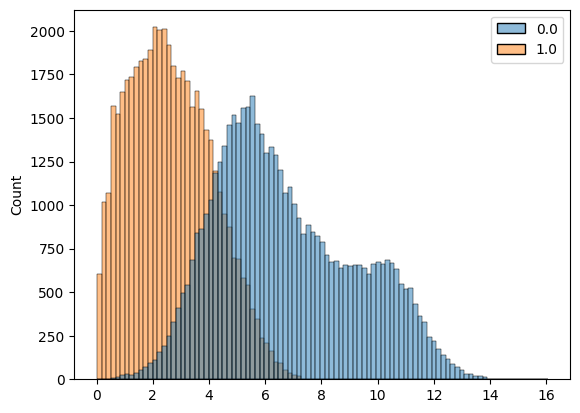

In [22]:
sns.histplot(data = dist_train, x = dist_train[:, -2], hue = dist_train[:, -1])
plt.show()

Гистограммы распределения говорят, что есть много объектов, которые расположены близко, но их не находят. Интересный факт.

Далее, посмотрим какие признаки вносят наибольший вклад в расстояние между объектами:

In [23]:
total = np.array([round(np.mean(dist_train[:, col]), 4) for col in range(len(train.columns) - 2)])
true = np.array([round(np.mean(dist_train[np.where((dist_train[:, -1] == 1) & (dist_train[:, -2] != 0)), col]), 4) for col in range(len(train.columns) - 2)])
false = np.array([round(np.mean(dist_train[np.where((dist_train[:, -1] == 0) & (dist_train[:, -2] != 0)), col]), 4) for col in range(len(train.columns) - 2)])
top_strong = 10
for arr in [(total, 'Всего по обучающему набору:'), (true, 'C меткой true:'), (false, 'С меткой false:')]:
    print(f'\n{arr[1]}')
    for idx in np.argsort(arr[0])[-top_strong:]:
        print(f'{idx}: {arr[0][idx]}')


Всего по обучающему набору:
51: 0.0032
23: 0.0032
70: 0.0149
44: 0.016
6: 0.0168
25: 0.0216
65: 0.0311
21: 0.0328
33: 0.1105
59: 0.1544

C меткой true:
4: 0.0012
3: 0.0012
70: 0.0143
44: 0.0161
6: 0.0178
25: 0.0183
65: 0.0299
21: 0.0383
33: 0.1709
59: 0.2703

С меткой false:
18: 0.0051
51: 0.0051
70: 0.0155
44: 0.0158
6: 0.0158
25: 0.0247
21: 0.0276
65: 0.0323
59: 0.0428
33: 0.0522


И вот здесь все тайное становится явным: признаки, на которые мы обращали внимание вносят значительно больший вклад в расстояние, чем остальные. Попробуем их исключить и провести поиск повторно.

## Исключение мешающих признаков

In [24]:
subset_to_drop = ['21', '25', '33', '44', '59', '65', '6', '70']
base_weak_cols = base[subset_to_drop]
train_weak_cols = train[subset_to_drop]
test_weak_cols = test[subset_to_drop]
base.drop(columns = subset_to_drop, inplace = True)
train.drop(columns = subset_to_drop, inplace = True)
test.drop(columns = subset_to_drop, inplace = True)

In [25]:
k = 100
topn = 30
dim = base.shape[1]
obj_cnt = train.shape[0]

quantizer = faiss.IndexFlatL2(dim)
index = faiss.IndexIVFFlat(quantizer, dim, k)
assert not index.is_trained
print(index.is_trained)
index.train(base.values)
assert index.is_trained
print(index.is_trained)
index.nprobe = 2

index.add(base.values)

False
True


In [26]:
%%time
D, I = index.search(train.values[:obj_cnt, 1:-1], topn)  # Возвращает результат: Distances, Indices 
X_train, y_train, id_pred = train_data_maker(I)
avg_depth = target_depth(id_pred)
print('accuracy:', y_train[:, 0].mean())

accuracy: 0.57581
CPU times: user 5min 39s, sys: 2.82 s, total: 5min 42s
Wall time: 1min 58s


Точность поиска значительно подросла - отлично!

In [27]:
depth = target_depth(id_pred)
print(depth)
print('total:', depth.sum())

[57581.  5312.  2216.  1343.   837.   665.   518.   414.   327.   289.
   259.   226.   212.   214.   184.   142.   134.   130.   143.   127.
   123.   109.    91.   110.    95.   103.    91.    85.    69.    87.]
total: 72236.0


И объектов находится значительно больше - тоже заслуга этих полей.

In [28]:
dist_train = L2_dist(train.values[:, 1:-1], base.loc[train.values[:, -1]].values, y_train[:, 0])
print(f'Среднее расстояние между векторами из обучающего набора: {round(np.mean(dist_train[:, -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой true: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 1), -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой false: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 0), -2]), 3)}')

Среднее расстояние между векторами из обучающего набора: 3.132
Среднее расстояние между векторами с меткой true: 1.003
Среднее расстояние между векторами с меткой false: 6.022


Среднее расстояние для объектов тоже уменьшилось, однако для тех, которым находится соответствие сильнее. Тоже хороший результат, посмотрим на распределение расстояний:

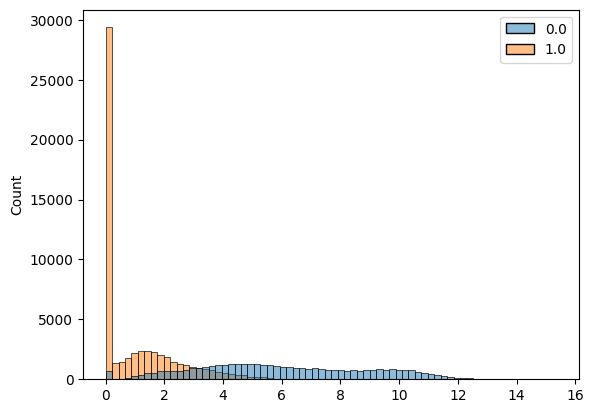

In [29]:
sns.histplot(data = dist_train, x = dist_train[:, -2], hue = dist_train[:, -1])
plt.show()

Объектов, расстояние от которых до искомого объекта близко нулю стало значительно больше, но среди них также есть и те, которые не первые в выдаче.

# Нормирование векторов объектов

Еще один способ изменить близость объектов - привести вектора объектов к единичным, нормировать. Это действие изменяет не признаки по-отдельности, а работает на уровне векторов - с каждым объектом. Проверим, как это повлияет на поисковые выдачи:

In [30]:
base.loc[:, :] = normalize(X = base.values, norm = 'l2')
train.loc[:, train.columns[1:-1]] = normalize(X = train.values[:, 1:-1], norm = 'l2')
test.loc[:, test.columns[1:]] = normalize(X = test.values[:, 1:], norm = 'l2')

In [31]:
k = 100
topn = 30
dim = base.shape[1]
obj_cnt = train.shape[0]

quantizer = faiss.IndexFlatL2(dim)
index = faiss.IndexIVFFlat(quantizer, dim, k)
assert not index.is_trained
print(index.is_trained)
index.train(base.values)
assert index.is_trained
print(index.is_trained)
index.nprobe = 2

index.add(base.values)

False
True


In [32]:
%%time
D, I = index.search(train.values[:obj_cnt, 1:-1], topn)  # Возвращает результат: Distances, Indices 
X_train, y_train, id_pred = train_data_maker(I)
avg_depth = target_depth(id_pred)
print('accuracy:', y_train[:, 0].mean())

accuracy: 0.57624
CPU times: user 5min 25s, sys: 1.82 s, total: 5min 27s
Wall time: 1min 53s


In [33]:
depth = target_depth(id_pred)
print(depth)
print('total:', depth.sum())

[57624.  5316.  2287.  1264.   829.   641.   528.   440.   325.   291.
   267.   236.   208.   202.   181.   137.   161.   139.   121.   111.
   133.   105.    80.   109.   106.    76.    94.    94.    67.    87.]
total: 72259.0


Точность поиска и количество найденных объектов не увеличилось кардинально, но увеличилось - можно оставить это преобразование.

**ПРИМЕЧАНИЕ:** Возможно стоит увеличить выборку и просматривать не 30, а например 100 объектов.

In [34]:
dist_train = L2_dist(train.values[:, 1:-1], base.loc[train.values[:, -1]].values, y_train[:, 0])
print(f'Среднее расстояние между векторами из обучающего набора: {round(np.mean(dist_train[:, -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой true: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 1), -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой false: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 0), -2]), 3)}')

Среднее расстояние между векторами из обучающего набора: 0.389
Среднее расстояние между векторами с меткой true: 0.122
Среднее расстояние между векторами с меткой false: 0.752


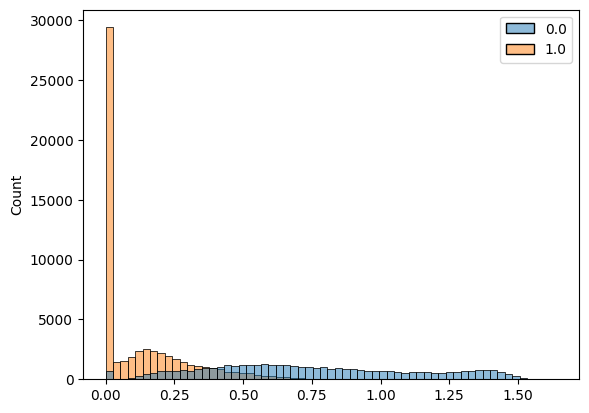

In [35]:
sns.histplot(data = dist_train, x = dist_train[:, -2], hue = dist_train[:, -1])
plt.show()

**ПРИМЕЧАНИЕ:**

Такого объема предобработки хватает, чтобы простым отбором ТОП-10 без переранжирования показать метрику 0.73730 на тестовой выборке с закрытой частью. Далее, попробуем настроить переранжирование внутри выборки FAISS.

# Ранжирование внутри группы

Для переранжирования будем использовать модель SGDClassifier из библиотеки sklearn, т.к. она одна из немного поддерживает режим обучения partial_fit, который здесь подходит лучше всего для обучения на мини-батчах из выдачи FAISS:

In [36]:
# X_train, y_train, id_pred
np.random.seed(RANDOM_SEED)
ttl_true = np.where(y_train[:, :] == 1)[0]
test_split = int(ttl_true.shape[0] * 0.25)
train_split = ttl_true.shape[0] - test_split
idx_test = np.random.choice(ttl_true, test_split, replace = False)
idx_train = np.random.choice(ttl_true, train_split, replace = False)

In [37]:
clf = SGDClassifier(max_iter = 1000, loss = 'log_loss', random_state = RANDOM_SEED, class_weight = {0 : 0.05, 1 : 0.95})
for idx in idx_train:
    clf.partial_fit(X_train[idx], y_train[idx], classes = np.array([0, 1]))

**ПРИМЕЧАНИЕ**

Из-за сжатых сроков не получилось выполнить полноценную проверку работы на тестовой выборке с контролем обучения и подбором гиперпараметров, поэтому проверим просто на одном объекте:

In [ ]:
idx = 1700
predict = clf.predict_proba(X_train[idx_test[idx]])
print(y_train[idx_test[idx]])
print(predict)
n = 5
print(np.argsort(predict[:, 1])[::-1])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[[0.72462713 0.27537287]
 [0.72833686 0.27166314]
 [0.72455758 0.27544242]
 [0.74088878 0.25911122]
 [0.71872733 0.28127267]
 [0.73217649 0.26782351]
 [0.73366115 0.26633885]
 [0.73569707 0.26430293]
 [0.73498653 0.26501347]
 [0.71798413 0.28201587]
 [0.68535472 0.31464528]
 [0.7217616  0.2782384 ]
 [0.75827037 0.24172963]
 [0.72515976 0.27484024]
 [0.7258695  0.2741305 ]
 [0.75056384 0.24943616]
 [0.75098113 0.24901887]
 [0.72300531 0.27699469]
 [0.72810348 0.27189652]
 [0.73824934 0.26175066]
 [0.71221033 0.28778967]
 [0.72387088 0.27612912]
 [0.73841955 0.26158045]
 [0.72914141 0.27085859]
 [0.726304   0.273696  ]
 [0.72710431 0.27289569]
 [0.70781024 0.29218976]
 [0.72232644 0.27767356]
 [0.73283354 0.26716646]
 [0.71824957 0.28175043]]
[10 26 20  9 29  4 11 27 17 21  2  0 13 14 24 25 18  1 23  5 28  6  8  7
 19 22  3 15 16 12]


Не самый лучший пример, проверим работу алгоритма сразу на лидерборде. Переранжирование будем выполнять по значению predict_proba и отбором ТОП-N объектов с помощью argsort. Обучим модель на полном тренировочном наборе:

In [39]:
clf = SGDClassifier(max_iter = 100, loss = 'log_loss', random_state = RANDOM_SEED, class_weight = {0 : 0.1, 1 : 0.9})
for idx in ttl_true:
    clf.partial_fit(X_train[idx], y_train[idx], classes = np.array([0, 1]))

## Формирование тестовой выгрузки

Для формирования тестовой выборки применим поиск без квантирования, возможно так мы получим лучший результат:

In [40]:
vectors_test = test.values

In [ ]:
%%time
topn = 30
dim = base.shape[1]
index = faiss.IndexFlatL2(dim)
print(index.ntotal)
index.add(base.values)
print(index.ntotal)

D, I = index.search(vectors_test[:, 1:], topn)  # Возвращает результат: Distances, Indices

0
2918139
CPU times: user 1h 11min 20s, sys: 3.7 s, total: 1h 11min 23s
Wall time: 18min 10s


In [ ]:
X_test, y_test, id_test = train_data_maker(I)

In [ ]:
%%time
n = 10
answers_df = pd.DataFrame(columns = ['Id', 'Predicted'])
for row in range(vectors_test.shape[0]):
    print(f'\r{row}/100000', end = '')
    label = test.loc[row, 'Id']
    predict = clf.predict_proba(X_test[row])    
    top10 = np.argsort(predict[:, 1])[:-(n+1):-1]
    pred = ' '.join(id_test[row, top10].tolist())
    answers_df.loc[-1] = [label, pred]
    answers_df.index = answers_df.index + 1

99999/100000CPU times: user 9min 6s, sys: 2.01 s, total: 9min 8s
Wall time: 9min 6s


In [ ]:
answers_df.head()
answers_df.to_csv('my_submission_ver06.csv', index=False)

К сожалению недонастроенное переранжирование не показало хороший результат и метрика ниже, чем в Leaderbord - 0.56041 на private score.

# Выводы

В данном проекте перед нами стояла задача решить усеченную версию матчинга - определить, являются ли два или более предмета эквивалентными или одним и тем же объектом.В качестве метрики выступал Recall@10: для каждого товара найти 10 наиболее близких кандидатов. Тогда:

**Recall@10 = (общая сумма найденных в топ10 матчей) / (общая сумма матчей)**

Данные были представлены в векторном виде, все поля закодированы числами. С помощью минимальной предобработки PowerTransformer'ом, нормализации векторов и подачи данных в таком виде на вход FAISS можно добиться хорошего результата Recall@10 = 0.73730 на private части таблицы лидеров. Настройка переранжирования в минимальном виде не дала увеличения метрики. Для улучшения работы алгоритма необходимо:
* увеличить количество данных в train выборке - нужно больше объектов соответствия и желательно веса связанные с их соответствием запросу;
* строить модель с контролем обучения и подбором гипрепараметров (GridSearchCV или Optuna);
* выбрать более сильную модель- например, CatBoostRanker.